In [28]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, accuracy_score, roc_curve, auc, recall_score, precision_score

from torch_geometric.nn import GCNConv
from torch.nn import Linear

2.0.1+cpu


In [29]:
# Berechnet Accuracy Score
def evaluateAccuracy(mymodel, data):
    mymodel.eval()
    with torch.no_grad():
        out, _ = mymodel(data.x, data.edge_index)
        predicted_labels = out.argmax(dim=1)
    return accuracy_score(data.y[data.test_mask].numpy(), predicted_labels[data.test_mask].numpy())

In [30]:
# Berechnet AUC ROC
def evaluateAUCROC(mymodel, data):
    mymodel.eval()
    with torch.no_grad():
        out, _ = mymodel(data.x, data.edge_index)
        predicted_labels = out[:, 1].cpu().numpy()
        true_labels = data.y.numpy()
        fpr, tpr, _ = roc_curve(true_labels[data.test_mask], predicted_labels[data.test_mask])
        roc_auc = auc(fpr, tpr)
    return roc_auc, fpr, tpr

In [31]:
# Berechnet Recall
def evaluateRecall(mymodel, data):
    mymodel.eval()
    with torch.no_grad():
        out, _ = mymodel(data.x, data.edge_index)
        predicted_labels = out.argmax(dim=1)

    ground_truth = data.y[data.test_mask].numpy()
    predicted_labels = predicted_labels[data.test_mask].numpy()

    recall = recall_score(ground_truth, predicted_labels)
    return recall

In [32]:
# Berechnet Precision
def evaluatePrecision(mymodel, data):
    mymodel.eval()
    with torch.no_grad():
        out, _ = mymodel(data.x, data.edge_index)
        predicted_labels = out.argmax(dim=1)

    ground_truth = data.y[data.test_mask].numpy()
    predicted_labels = predicted_labels[data.test_mask].numpy()

    precision = precision_score(ground_truth, predicted_labels)
    return precision

In [33]:
# Berechnet F1 Score
def evaluateF1(mymodel):
    mymodel.eval()
    with torch.no_grad():
        out, _ = mymodel(usu_graph.x, usu_graph.edge_index)
        predicted_labels = out.argmax(dim=1).cpu().numpy()
    true_labels = usu_graph.y.numpy()
    f1 = f1_score(true_labels[usu_graph.test_mask], predicted_labels[usu_graph.test_mask], average='macro')
    return f1

In [34]:
# Lädt Daten
usu_graph = torch.load('Graph/usu_graph.pth')
usu_graph_oversampled_easy = torch.load('Graph/syntetic_data.pth')

# Standard

In [35]:
"""
Graph Convolutional Network
Features: 25, Ausgabe: 2
out: endgültige Vorhersage des Modells, h: Darstellung des Graphen nach den Transformationen durch die GCN-Schichten ist
"""
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(25, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, 2)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()

        out = self.classifier(h)

        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(25, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=2, bias=True)
)


In [36]:
# Training
model = GCN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

def train(data):
    optimizer.zero_grad()
    out, h = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss, h

for epoch in range(150):
    loss, h = train(usu_graph)
    print(f'Epoch: {epoch}, Loss: {loss}')

Epoch: 0, Loss: 0.9165054559707642
Epoch: 1, Loss: 0.8757396936416626
Epoch: 2, Loss: 0.837192177772522
Epoch: 3, Loss: 0.8007850050926208
Epoch: 4, Loss: 0.7663958072662354
Epoch: 5, Loss: 0.7338666319847107
Epoch: 6, Loss: 0.7031211256980896
Epoch: 7, Loss: 0.6740131378173828
Epoch: 8, Loss: 0.6463943123817444
Epoch: 9, Loss: 0.6201349496841431
Epoch: 10, Loss: 0.595116376876831
Epoch: 11, Loss: 0.5712305903434753
Epoch: 12, Loss: 0.5483885407447815
Epoch: 13, Loss: 0.5265418291091919
Epoch: 14, Loss: 0.5056853890419006
Epoch: 15, Loss: 0.4857933521270752
Epoch: 16, Loss: 0.46685484051704407
Epoch: 17, Loss: 0.4488848149776459
Epoch: 18, Loss: 0.4318750202655792
Epoch: 19, Loss: 0.4158582389354706
Epoch: 20, Loss: 0.40082937479019165
Epoch: 21, Loss: 0.38678890466690063
Epoch: 22, Loss: 0.37373122572898865
Epoch: 23, Loss: 0.3616305887699127
Epoch: 24, Loss: 0.3504321575164795
Epoch: 25, Loss: 0.3401104509830475
Epoch: 26, Loss: 0.3306248188018799
Epoch: 27, Loss: 0.32194024324417114

In [37]:
torch.save(model, 'Models/standard.pth')

# Gewichtete Verlustfunktion

In [38]:
"""
Graph Convolutional Network
drei GCN-Schichten (GCNConv) und eine lineare Schicht (Linear)
Features: 25, Ausgabe: 2
out: endgültige Vorhersage des Modells, h: Darstellung des Graphen nach den Transformationen durch die GCN-Schichten ist
"""
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(25, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, 2)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()

        out = self.classifier(h)

        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(25, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=2, bias=True)
)


In [39]:
# gewichtete Trainingsfunktion
model = GCN()

weight_class_0 = 1.0
weight_class_1 = 5.0
class_weights = torch.Tensor([weight_class_0, weight_class_1])

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

def train(data):
    optimizer.zero_grad()
    out, h = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss, h

for epoch in range(150):
    loss, h = train(usu_graph)
    print(f'Epoch: {epoch}, Loss: {loss}')

Epoch: 0, Loss: 0.8211929202079773
Epoch: 1, Loss: 0.7950437664985657
Epoch: 2, Loss: 0.770831286907196
Epoch: 3, Loss: 0.7484997510910034
Epoch: 4, Loss: 0.7279432415962219
Epoch: 5, Loss: 0.7090468406677246
Epoch: 6, Loss: 0.6917185187339783
Epoch: 7, Loss: 0.6758506298065186
Epoch: 8, Loss: 0.661325991153717
Epoch: 9, Loss: 0.648041307926178
Epoch: 10, Loss: 0.6359065175056458
Epoch: 11, Loss: 0.6248509883880615
Epoch: 12, Loss: 0.6148212552070618
Epoch: 13, Loss: 0.6057900190353394
Epoch: 14, Loss: 0.5977352857589722
Epoch: 15, Loss: 0.5906287431716919
Epoch: 16, Loss: 0.5844376683235168
Epoch: 17, Loss: 0.5791180729866028
Epoch: 18, Loss: 0.5745773911476135
Epoch: 19, Loss: 0.5707274675369263
Epoch: 20, Loss: 0.5674394965171814
Epoch: 21, Loss: 0.5645534992218018
Epoch: 22, Loss: 0.5619769096374512
Epoch: 23, Loss: 0.5596712827682495
Epoch: 24, Loss: 0.5574339032173157
Epoch: 25, Loss: 0.5553075671195984
Epoch: 26, Loss: 0.5534754991531372
Epoch: 27, Loss: 0.5516083836555481
Epoch

In [40]:
torch.save(model, 'Models/gewichteteLoss.pth')

# Dropout Layer und Batch Normalize

In [41]:
# GCN
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(25, 4)
        self.bn1 = torch.nn.BatchNorm1d(4)
        self.dropout1 = torch.nn.Dropout(0.5)
        self.conv2 = GCNConv(4, 4)
        self.bn2 = torch.nn.BatchNorm1d(4)
        self.dropout2 = torch.nn.Dropout(0.5)
        self.conv3 = GCNConv(4, 2)
        self.bn3 = torch.nn.BatchNorm1d(2)
        self.dropout3 = torch.nn.Dropout(0.5)
        self.classifier = Linear(2, 2)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = self.bn1(h)
        h = h.tanh()
        h = self.dropout1(h)
        h = self.conv2(h, edge_index)
        h = self.bn2(h)
        h = h.tanh()
        h = self.dropout2(h)
        h = self.conv3(h, edge_index)
        h = self.bn3(h)
        h = h.tanh()
        h = self.dropout3(h)

        out = self.classifier(h)

        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(25, 4)
  (bn1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): GCNConv(4, 4)
  (bn2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): GCNConv(4, 2)
  (bn3): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (classifier): Linear(in_features=2, out_features=2, bias=True)
)


In [42]:
# Trainingsfunktion
model = GCN()

weight_class_0 = 1.0
weight_class_1 = 5.0
class_weights = torch.Tensor([weight_class_0, weight_class_1])

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

def train(data):
    optimizer.zero_grad()
    out, h = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss, h

for epoch in range(150):
    loss, h = train(usu_graph)
    print(f'Epoch: {epoch}, Loss: {loss}')

Epoch: 0, Loss: 0.9451559782028198
Epoch: 1, Loss: 0.9339910745620728
Epoch: 2, Loss: 0.9260878562927246
Epoch: 3, Loss: 0.9077959656715393
Epoch: 4, Loss: 0.8949931859970093
Epoch: 5, Loss: 0.8849787712097168
Epoch: 6, Loss: 0.8755815029144287
Epoch: 7, Loss: 0.8649537563323975
Epoch: 8, Loss: 0.8592509627342224
Epoch: 9, Loss: 0.8498400449752808
Epoch: 10, Loss: 0.8405616879463196
Epoch: 11, Loss: 0.8331317901611328
Epoch: 12, Loss: 0.8191952109336853
Epoch: 13, Loss: 0.8127669095993042
Epoch: 14, Loss: 0.7983057498931885
Epoch: 15, Loss: 0.7955847382545471
Epoch: 16, Loss: 0.7840031981468201
Epoch: 17, Loss: 0.7748575806617737
Epoch: 18, Loss: 0.7645233273506165
Epoch: 19, Loss: 0.760486364364624
Epoch: 20, Loss: 0.7463226914405823
Epoch: 21, Loss: 0.7413080930709839
Epoch: 22, Loss: 0.7297562956809998
Epoch: 23, Loss: 0.7228385210037231
Epoch: 24, Loss: 0.710679292678833
Epoch: 25, Loss: 0.7073660492897034
Epoch: 26, Loss: 0.6974738836288452
Epoch: 27, Loss: 0.6854221224784851
Epoc

In [43]:
torch.save(model, 'Models/batchNorm.pth')

# Synthetischer Datensatz

In [44]:
# GCN
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(25, 4)
        self.bn1 = torch.nn.BatchNorm1d(4)
        self.dropout1 = torch.nn.Dropout(0.5)
        self.conv2 = GCNConv(4, 4)
        self.bn2 = torch.nn.BatchNorm1d(4)
        self.dropout2 = torch.nn.Dropout(0.5)
        self.conv3 = GCNConv(4, 2)
        self.bn3 = torch.nn.BatchNorm1d(2)
        self.dropout3 = torch.nn.Dropout(0.5)
        self.classifier = Linear(2, 2)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = self.bn1(h)
        h = h.tanh()
        h = self.dropout1(h)
        h = self.conv2(h, edge_index)
        h = self.bn2(h)
        h = h.tanh()
        h = self.dropout2(h)
        h = self.conv3(h, edge_index)
        h = self.bn3(h)
        h = h.tanh()
        h = self.dropout3(h)

        out = self.classifier(h)

        return out, h


model = GCN()
print(model)

GCN(
  (conv1): GCNConv(25, 4)
  (bn1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): GCNConv(4, 4)
  (bn2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): GCNConv(4, 2)
  (bn3): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (classifier): Linear(in_features=2, out_features=2, bias=True)
)


In [45]:
# Trainigsfunktion
model = GCN()

weight_class_0 = 1.0
weight_class_1 = 5.0
class_weights = torch.Tensor([weight_class_0, weight_class_1])

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

def train(data):
    optimizer.zero_grad()
    out, h = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss, h

for epoch in range(150):
    loss, h = train(usu_graph_oversampled_easy)
    print(f'Epoch: {epoch}, Loss: {loss}')

Epoch: 0, Loss: 0.771479070186615
Epoch: 1, Loss: 0.7718269228935242
Epoch: 2, Loss: 0.7669517397880554
Epoch: 3, Loss: 0.7550415992736816
Epoch: 4, Loss: 0.7519038915634155
Epoch: 5, Loss: 0.7423825263977051
Epoch: 6, Loss: 0.7344754338264465
Epoch: 7, Loss: 0.7359898686408997
Epoch: 8, Loss: 0.732512891292572
Epoch: 9, Loss: 0.7283227443695068
Epoch: 10, Loss: 0.7198048233985901
Epoch: 11, Loss: 0.7130639553070068
Epoch: 12, Loss: 0.7096067070960999
Epoch: 13, Loss: 0.7074815034866333
Epoch: 14, Loss: 0.7006235718727112
Epoch: 15, Loss: 0.6989489197731018
Epoch: 16, Loss: 0.6980144381523132
Epoch: 17, Loss: 0.6961043477058411
Epoch: 18, Loss: 0.690750241279602
Epoch: 19, Loss: 0.6870208978652954
Epoch: 20, Loss: 0.6851810812950134
Epoch: 21, Loss: 0.6837525963783264
Epoch: 22, Loss: 0.6812517642974854
Epoch: 23, Loss: 0.6806206107139587
Epoch: 24, Loss: 0.6760877966880798
Epoch: 25, Loss: 0.6825188994407654
Epoch: 26, Loss: 0.6688545942306519
Epoch: 27, Loss: 0.667036235332489
Epoch:

In [46]:
torch.save(model, 'Models/synthetic.pth')

# Load Models

In [47]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(25, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, 2)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()

        out = self.classifier(h)

        return out, h

model_standard = torch.load('Models/standard.pth')
print(model_standard)
model_weightedLoss = torch.load('Models/gewichteteLoss.pth')
print(model_weightedLoss)

GCN(
  (conv1): GCNConv(25, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=2, bias=True)
)
GCN(
  (conv1): GCNConv(25, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=2, bias=True)
)


In [48]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(25, 4)
        self.bn1 = torch.nn.BatchNorm1d(4)
        self.dropout1 = torch.nn.Dropout(0.5)
        self.conv2 = GCNConv(4, 4)
        self.bn2 = torch.nn.BatchNorm1d(4)
        self.dropout2 = torch.nn.Dropout(0.5)
        self.conv3 = GCNConv(4, 2)
        self.bn3 = torch.nn.BatchNorm1d(2)
        self.dropout3 = torch.nn.Dropout(0.5)
        self.classifier = Linear(2, 2)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = self.bn1(h)
        h = h.tanh()
        h = self.dropout1(h)
        h = self.conv2(h, edge_index)
        h = self.bn2(h)
        h = h.tanh()
        h = self.dropout2(h)
        h = self.conv3(h, edge_index)
        h = self.bn3(h)
        h = h.tanh()
        h = self.dropout3(h)

        out = self.classifier(h)

        return out, h

model = GCN()

model_batchNorm = torch.load('Models/batchNorm.pth')
model_synthetic = torch.load('Models/synthetic.pth')
print(model_batchNorm)
print(model_synthetic)

GCN(
  (conv1): GCNConv(25, 4)
  (bn1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): GCNConv(4, 4)
  (bn2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): GCNConv(4, 2)
  (bn3): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (classifier): Linear(in_features=2, out_features=2, bias=True)
)
GCN(
  (conv1): GCNConv(25, 4)
  (bn1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): GCNConv(4, 4)
  (bn2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): GCNConv(4, 2)
  (bn3): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p

# Accuracy Score

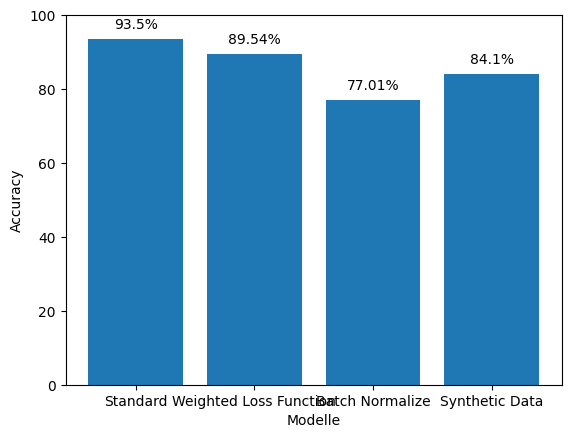

In [49]:
# Visualisiert Accuracy Score
accuracy_standard = evaluateAccuracy(model_standard, usu_graph) * 100
accuracy_weightedLoss = evaluateAccuracy(model_weightedLoss, usu_graph) * 100
accuracy_batchNorm = evaluateAccuracy(model_batchNorm, usu_graph) * 100
accuracy_synthetic = evaluateAccuracy(model_synthetic, usu_graph_oversampled_easy) * 100

x_labels = ["Standard", "Weighted Loss Function", "Batch Normalize", "Synthetic Data"]
y_percentages = [accuracy_standard, accuracy_weightedLoss, accuracy_batchNorm, accuracy_synthetic]

plt.bar(x_labels, y_percentages)
plt.xlabel('Modelle')
plt.ylabel('Accuracy')
plt.ylim(0, 100)
for i, percentage in enumerate(y_percentages):
    rounded_percentage = round(percentage, 2)
    plt.text(i, percentage + 2, f"{rounded_percentage}%", ha='center', va='bottom')
plt.savefig('Images/Metrics/accuracy.png')
plt.show()

# AUC-ROC Score

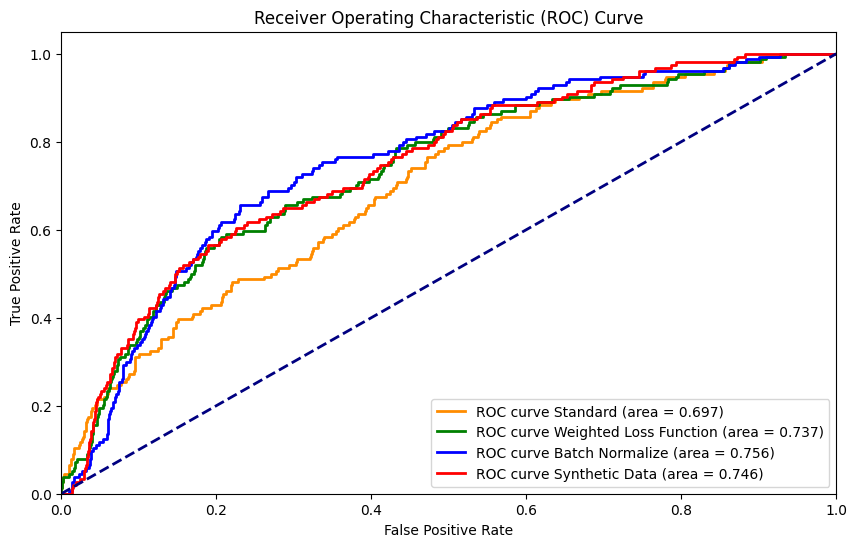

In [50]:
# Visualisiert AUC ROC
aucroc_standard, fpr_standard, tpr_standard  = evaluateAUCROC(model_standard, usu_graph)
aucroc_weightedLoss, fpr_weightedLoss, tpr_weigthedLoss = evaluateAUCROC(model_weightedLoss, usu_graph)
aucroc_batchNorm, fpr_batchNorm, tpr_batchNorm = evaluateAUCROC(model_batchNorm, usu_graph)
aucroc_synthetic, fpr_synthetic, tpr_synthetic = evaluateAUCROC(model_synthetic, usu_graph_oversampled_easy)

plt.figure(figsize=(10, 6))
plt.plot(fpr_standard, tpr_standard, color='darkorange', lw=2, label='ROC curve Standard (area = {:.3f})'.format(aucroc_standard))
plt.plot(fpr_weightedLoss, tpr_weigthedLoss, color='green', lw=2, label='ROC curve Weighted Loss Function (area = {:.3f})'.format(aucroc_weightedLoss))
plt.plot(fpr_batchNorm, tpr_batchNorm, color='blue', lw=2, label='ROC curve Batch Normalize (area = {:.3f})'.format(aucroc_batchNorm))
plt.plot(fpr_synthetic, tpr_synthetic, color='red', lw=2, label='ROC curve Synthetic Data (area = {:.3f})'.format(aucroc_synthetic))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig('Images/Metrics/aucroc.png')
plt.show()

# Recall

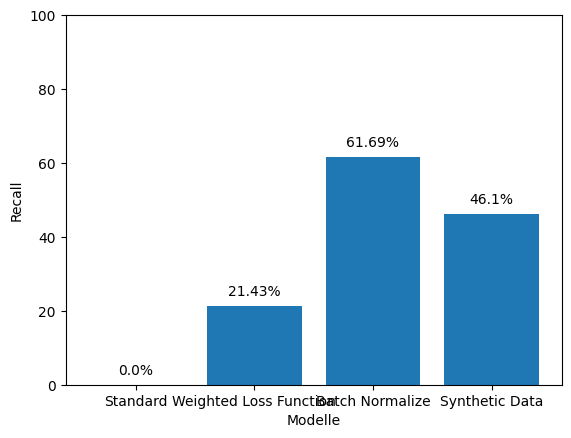

In [51]:
# Visualisiert Recall
recall_standard = evaluateRecall(model_standard, usu_graph) * 100
recall_weightedLoss = evaluateRecall(model_weightedLoss, usu_graph) * 100
recall_batchNorm = evaluateRecall(model_batchNorm, usu_graph) * 100
recall_synthetic = evaluateRecall(model_synthetic, usu_graph_oversampled_easy) * 100

x_labels = ['Standard', 'Weighted Loss Function', 'Batch Normalize', 'Synthetic Data']
y_percentages = [recall_standard, recall_weightedLoss, recall_batchNorm, recall_synthetic]

plt.bar(x_labels, y_percentages)
plt.xlabel('Modelle')
plt.ylabel('Recall')
plt.ylim(0, 100)
for i, percentage in enumerate(y_percentages):
    rounded_percentage = round(percentage, 2)
    plt.text(i, percentage + 2, f"{rounded_percentage}%", ha='center', va='bottom')
plt.savefig('Images/Metrics/recovered.png')
plt.show()

# Precision

D:\masterarbeit\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


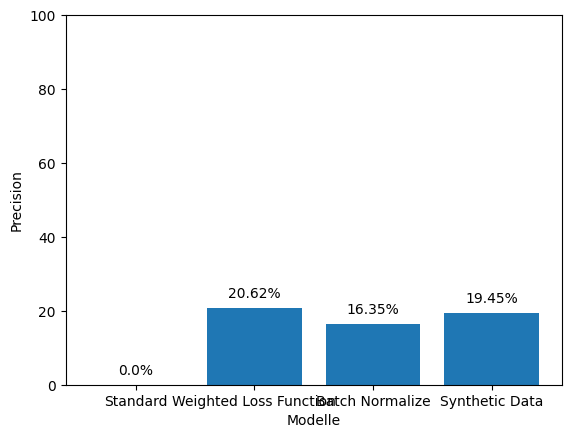

In [52]:
# Visualisiert Precision
precision_standard = evaluatePrecision(model_standard, usu_graph) * 100
precision_weigthedLoss = evaluatePrecision(model_weightedLoss, usu_graph) * 100
precision_batchNorm = evaluatePrecision(model_batchNorm, usu_graph) * 100
precision_synthetic = evaluatePrecision(model_synthetic, usu_graph_oversampled_easy) * 100

x_labels = ["Standard", "Weighted Loss Function", "Batch Normalize", "Synthetic Data"]
y_percentages = [precision_standard, precision_weigthedLoss, precision_batchNorm, precision_synthetic]

plt.bar(x_labels, y_percentages)
plt.xlabel('Modelle')
plt.ylabel('Precision')
plt.ylim(0, 100)
for i, percentage in enumerate(y_percentages):
    rounded_percentage = round(percentage, 2)
    plt.text(i, percentage + 2, f"{rounded_percentage}%", ha='center', va='bottom')
plt.savefig('Images/Metrics/f1.png')
plt.show()

# F1 Score

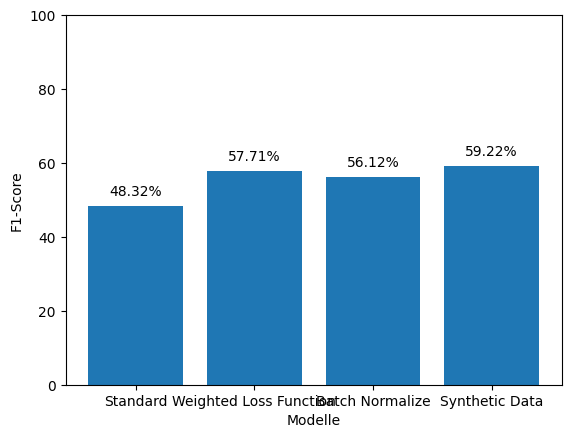

In [53]:
# Visualisiert F1 Score
f1_standard = evaluateF1(model_standard) * 100
f1_weigthedLoss = evaluateF1(model_weightedLoss) * 100
f1_batchNorm = evaluateF1(model_batchNorm) * 100
f1_synthetic = evaluateF1(model_synthetic) * 100

x_labels = ["Standard", "Weighted Loss Function", "Batch Normalize", "Synthetic Data"]
y_percentages = [f1_standard, f1_weigthedLoss, f1_batchNorm, f1_synthetic]

plt.bar(x_labels, y_percentages)
plt.xlabel('Modelle')
plt.ylabel('F1-Score')
plt.ylim(0, 100)
for i, percentage in enumerate(y_percentages):
    rounded_percentage = round(percentage, 2)
    plt.text(i, percentage + 2, f"{rounded_percentage}%", ha='center', va='bottom')
plt.savefig('Images/Metrics/f1.png')
plt.show()